### Подготовка к выполнению задачи

In [52]:
# Импорты 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Загрузка данных
item = 'Mroz'                                                                                         # Указываем название набора данных
package = 'Ecdat'                                                                                     # Указываем пакет с данным набором
df = sm.datasets.get_rdataset(item, package, cache=True).data                                         # Загружаем данные из statsmodels

# Очистка данных
df = df[['wagew', 'educw', 'agew', 'child6']].dropna()                                                # Отбираем только нужные колонки и удаляем строки с пропусками
df['child6'] = df['child6'].apply(lambda x: 1 if x == 'yes' else 0)                                   # Преобразуем 'yes' в 1 и 'no' в 0 для переменной child6

# Проверка данных на пропуски
print("Проверка данных на пропуски:")
print(df.isnull().sum())                                                                              # Проверка на пропуски в данных
print(df.head())                                                                                      # Выводим первые 5 строк данных для проверки

Проверка данных на пропуски:
wagew     0
educw     0
agew      0
child6    0
dtype: int64
   wagew  educw  agew  child6
0   2.65     12    32       0
1   2.65     12    30       0
2   4.04     12    35       0
3   3.25     12    34       0
4   3.60     14    31       0


### Пункт 2: Формулировка задачи
Задача:

Предсказать почасовую зарплату жены (wagew) в зависимости от:
- Уровня образования (educw),
- Возраста (agew),
- Наличия детей младше 6 лет (child6).

Обоснование:
Эти переменные имеют потенциально значимое влияние на заработок, и результаты анализа могут быть использованы для различных программ.

### Пункт 3: Разделение данных

In [58]:
# Разделяем датасет на признаки (X) и целевую переменную (y)

# Разделение данных на обучающие и тестовые
X = df[['educw', 'agew', 'child6']]                                                              # Признаки (образование, возраст и наличие детей)
y = df['wagew']                                                                                  # Целевая переменная (зарплата)

# Разделяем данные на обучающую выборку (60%) и тестовую выборку (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Тестовую выборку делим на две части по 20% каждая
X_val, X_predict, y_val, y_predict = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Проверяем размеры выборок
print("Обучающая выборка:", X_train.shape)
print("Тестовая выборка (оценка):", X_val.shape)
print("Тестовая выборка (прогноз):", X_predict.shape)


Обучающая выборка: (451, 3)
Тестовая выборка (оценка): (151, 3)
Тестовая выборка (прогноз): (151, 3)


### Пункт 4: Обучение моделей

In [59]:
# Нормализация данных
scaler = StandardScaler()                                                                                  # Создаем объект для нормализации
X_train_scaled = scaler.fit_transform(X_train)                                                             # Нормализуем обучающие данные
X_val_scaled = scaler.transform(X_val)                                                                     # Нормализуем валидационные данные
X_predict_scaled = scaler.transform(X_predict)                                                             # Нормализуем данные для прогнозирования

# Дополнительные трансформации
# Полиномиальные признаки до 3-й степени
poly = PolynomialFeatures(degree=3, include_bias=False)                                                    # Степень полинома 3
X_train_poly = poly.fit_transform(X_train_scaled)                                                          # Преобразуем обучающие данные в полиномиальные
X_val_poly = poly.transform(X_val_scaled)                                                                  # Преобразуем валидационные данные
X_predict_poly = poly.transform(X_predict_scaled)                                                          # Преобразуем данные для прогнозирования

# Логарифмическая трансформация целевой переменной (для стабилизации дисперсии и улучшения модели)
log_transformer = FunctionTransformer(np.log1p, validate=True)                                             # Логарифмическая трансформация
y_train_log = log_transformer.fit_transform(y_train.values.reshape(-1, 1)).flatten()                       # Преобразуем обучающие данные
y_val_log = log_transformer.transform(y_val.values.reshape(-1, 1)).flatten()                               # Преобразуем валидационные данные

# Обучение моделей
models = {
    "Linear Regression": LinearRegression(),                                                               # Линейная регрессия
    "Decision Tree": DecisionTreeRegressor(random_state=42),                                               # Дерево решений
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)                                        # Градиентный бустинг
}

# Параметры для поиска гиперпараметров для каждой модели
param_grid_tree = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}                               # Для дерева решений
param_grid_gb = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1]}                     # Для градиентного бустинга

# Используем GridSearchCV для поиска оптимальных гиперпараметров
tree_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_tree, cv=3, scoring='neg_mean_squared_error')
gb_cv = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, scoring='neg_mean_squared_error')

### Пункт 5: Выбор лучшей модели

In [60]:
results = {}
for name, model in models.items():
    if name == "Decision Tree":
        model = tree_cv.fit(X_train_poly, y_train_log)                                          # Для дерева ищем оптимальные параметры
    elif name == "Gradient Boosting":
        model = gb_cv.fit(X_train_poly, y_train_log)                                            # Для градиентного бустинга ищем оптимальные параметры
    else:
        model.fit(X_train_poly, y_train_log)                                                    # Для линейной регрессии обучаем модель
    
    y_pred_log = model.predict(X_val_poly)                                                      # Предсказание на валидационных данных
    y_pred = np.expm1(y_pred_log)                                                               # Обратная логарифмическая трансформация для восстановления исходных значений
    mae = mean_absolute_error(y_val, y_pred)                                                    # Вычисляем MAE
    mse = mean_squared_error(y_val, y_pred)                                                     # Вычисляем MSE
    results[name] = {"MAE": mae, "MSE": mse, "Model": model}                                    # Сохраняем результаты

# Вывод результатов
print("Результаты моделей:")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, MSE={metrics['MSE']:.2f}")                        # Выводим ошибки для каждой модели

Результаты моделей:
Linear Regression: MAE=1.93, MSE=6.21
Decision Tree: MAE=1.85, MSE=5.86
Gradient Boosting: MAE=1.93, MSE=6.21


На данном этапе мы сравнили три модели. Модель с наименьшими ошибками MAE и MSE показывает лучшее качество. В нашем случае модель Decision Tree

### Визуализация результатов

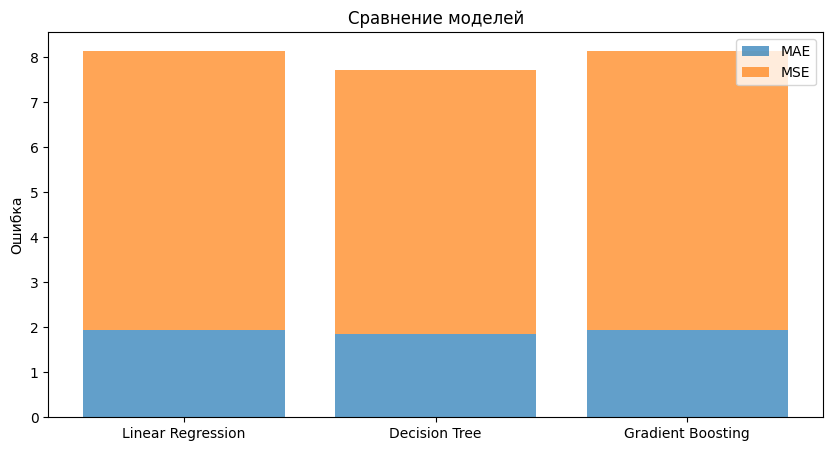

In [61]:
# Визуализация результатов
names = list(results.keys())                                                                       # Имена моделей
mae_values = [metrics['MAE'] for metrics in results.values()]                                      # Значения MAE
mse_values = [metrics['MSE'] for metrics in results.values()]                                      # Значения MSE

plt.figure(figsize=(10, 5))                                                                        # Создаем график
plt.bar(names, mae_values, alpha=0.7, label='MAE')                                                 # Столбцы для MAE
plt.bar(names, mse_values, alpha=0.7, label='MSE', bottom=mae_values)                              # Столбцы для MSE, начиная с MAE
plt.title("Сравнение моделей")                                                                     # Заголовок
plt.ylabel("Ошибка")                                                                               # Подпись оси Y
plt.legend()                                                                                       # Легенда
plt.show()

###  Прогнозирование на новых данных

In [62]:
best_model_name = min(results, key=lambda x: results[x]['MSE'])                                    # Выбираем модель с минимальной MSE
best_model = results[best_model_name]['Model']                                                     # Получаем лучшую модель
print(f"Лучшая модель: {best_model_name}")

final_predictions_log = best_model.predict(X_predict_poly)                                         # Прогноз на тестовых данных
final_predictions = np.expm1(final_predictions_log)                                                # Обратная логарифмическая трансформация
predictions_df = pd.DataFrame({"Actual": y_predict, "Predicted": final_predictions})               # Формируем DataFrame с реальными и предсказанными значениями
print("Предсказания:")
print(predictions_df.head())                                                                       # Выводим первые строки с предсказаниями

Лучшая модель: Decision Tree
Предсказания:
     Actual  Predicted
41     3.50   0.375371
589    0.00   1.138458
715    0.00   0.870324
340    1.50   3.578373
148    9.98   1.138458


### Выводы

Прогнозы для некоторых примеров значительно отличаются от реальных значений (например, для 3.50 модель предсказывает 0.37, для 9.98 — 1.14). Это говорит о том, что модель плохо аппроксимирует данные и делает сильные ошибки на прогнозах.

Причин может быть много, к примеру сама модель дерева решений может переобучаться на данных или для этой задачи логарифм не является оптимальной трансформацией, ну или данные не имеют явно выраженных нелинейных зависимостей.

### Но мне кажется, что причина именно в выборе переменных

Я использую всего 3 независимых переменных: educw, agew и child6. Эти переменные могут быть недостаточно информативными для предсказания заработной платы, и возможно, стоит использовать дополнительные признаки, такие как опыт работы, демографические или социально-экономические факторы, если они есть.

Я пробовал использовать XGBoost, LightGBM, SVR, но результат не сильно впечатляет и близок к текущему (я и модели менял, Random Forest был забавным)

Несколько дней эти ресурсы изучал:

- https://www.rasgoml.com/feature-engineering-tutorials/how-to-do-robust-scaler-normalization-with-pandas-and-scikit-learn
- https://proclusacademy.com/blog/robust-scaler-outliers/

И stackoverflow 

Нужно было самому всё попробовать

MAE для Gradient Boosting: 7.17, MSE: 56.39
MAE для Quantile Regression: 7.12, MSE: 107.94
Лучшая модель после доработки: Gradient Boosting (RandomizedSearch)
Предсказания:
     Actual  Predicted Gradient Boosting  Predicted Quantile Regression
41     3.50                   -11.913249                     -13.815511
589    0.00                    -8.139255                     -13.815511
715    0.00                    -5.545121                     -13.815511
340    1.50                    -2.257994                     -13.815511
148    9.98                    -9.034679                     -13.815511


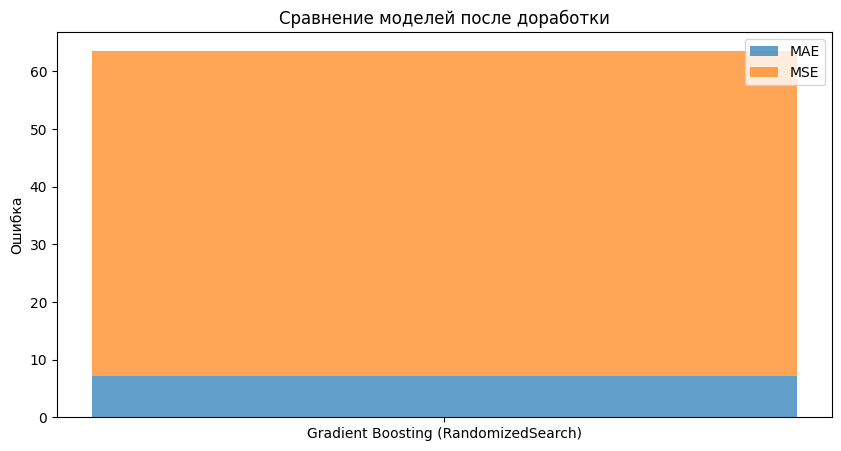

Предсказания после обратного преобразования:
     Actual  Predicted Gradient Boosting  Predicted Quantile Regression
41     3.50                     0.000008                   4.235165e-22
589    0.00                     0.003707                   4.235165e-22
715    0.00                     0.001863                   4.235165e-22
340    1.50                     0.001044                   4.235165e-22
148    9.98                     0.000113                   4.235165e-22


In [82]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import QuantileRegressor
import matplotlib.pyplot as plt
import numpy as np

# Дополнительная обработка данных
# Используем RobustScaler для улучшения работы модели с выбросами
scaler_robust = RobustScaler()
X_train_scaled_robust = scaler_robust.fit_transform(X_train)
X_val_scaled_robust = scaler_robust.transform(X_val)
X_predict_scaled_robust = scaler_robust.transform(X_predict)

# Преобразование целевой переменной с добавлением константы ---
epsilon = 1e-6  # Небольшая константа для корректного логарифмирования
y_train_log = np.log(y_train + epsilon)
y_val_log = np.log(y_val + epsilon)
y_predict_log = np.log(y_predict + epsilon)

# Более тщательный подбор гиперпараметров
param_dist_gb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Применяем RandomizedSearchCV для Gradient Boosting
gb_random_search = RandomizedSearchCV(gb_model, param_distributions=param_dist_gb, n_iter=50, cv=3, random_state=42, scoring='neg_mean_squared_error')
gb_random_search.fit(X_train_scaled_robust, y_train_log)

# Оценка модели с новым подбором гиперпараметров
y_pred_gb_random = gb_random_search.predict(X_val_scaled_robust)
mae_gb_random = mean_absolute_error(y_val_log, y_pred_gb_random)
mse_gb_random = mean_squared_error(y_val_log, y_pred_gb_random)
results['Gradient Boosting (RandomizedSearch)'] = {"MAE": mae_gb_random, "MSE": mse_gb_random, "Model": gb_random_search.best_estimator_}

# Квантильная регрессия
quantile_regressor = QuantileRegressor(alpha=0.1, quantile=0.5)  # 50-й квантиль (медиана)
quantile_regressor.fit(X_train_scaled_robust, y_train_log)

# Прогнозирование
y_pred_quantile = quantile_regressor.predict(X_val_scaled_robust)
mae_quantile = mean_absolute_error(y_val_log, y_pred_quantile)
mse_quantile = mean_squared_error(y_val_log, y_pred_quantile)

# Сравнение моделей
print(f"MAE для Gradient Boosting: {mae_gb_random:.2f}, MSE: {mse_gb_random:.2f}")
print(f"MAE для Quantile Regression: {mae_quantile:.2f}, MSE: {mse_quantile:.2f}")

# Прогнозирование лучшей модели
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = results[best_model_name]['Model']
print(f"Лучшая модель после доработки: {best_model_name}")

# Прогнозы с лучшей моделью
final_predictions = best_model.predict(X_predict_scaled_robust)
predictions_df = pd.DataFrame({"Actual": y_predict, "Predicted Gradient Boosting": final_predictions})

# Прогнозы с квантильной регрессией
final_predictions_quantile = quantile_regressor.predict(X_predict_scaled_robust)
predictions_df["Predicted Quantile Regression"] = final_predictions_quantile

print("Предсказания:")
print(predictions_df.head())

# Визуализация
names = list(results.keys())
mae_values = [metrics['MAE'] for metrics in results.values()]
mse_values = [metrics['MSE'] for metrics in results.values()]

plt.figure(figsize=(10, 5))
plt.bar(names, mae_values, alpha=0.7, label='MAE')
plt.bar(names, mse_values, alpha=0.7, label='MSE', bottom=mae_values)
plt.title("Сравнение моделей после доработки")
plt.ylabel("Ошибка")
plt.legend()
plt.show()

# Преобразование обратно из логарифмированных значений
y_pred_gb_random_exp = np.exp(y_pred_gb_random) - epsilon  # Обратное преобразование для Gradient Boosting
y_pred_quantile_exp = np.exp(y_pred_quantile) - epsilon  # Обратное преобразование для Quantile Regression

# Визуализация предсказаний
predictions_df['Predicted Gradient Boosting'] = y_pred_gb_random_exp
predictions_df['Predicted Quantile Regression'] = y_pred_quantile_exp

print("Предсказания после обратного преобразования:")
print(predictions_df.head())


НО результат всё равно проблемный :(  

Была получена рекомендация: Попробуйте не делать лог-трансформацию целевой переменной и убрать выбросы. Такое ощущение, что модель занижает предсказываемые значения, т.е. в данных перекос в сторону большего количества низких значений. Если убрать выбросы, результат может выровняться.

C:\Users\SWS-M\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Результаты моделей:
Linear Regression: MAE=1.71, MSE=3.68
Decision Tree: MAE=1.82, MSE=4.40
Gradient Boosting: MAE=1.75, MSE=3.88


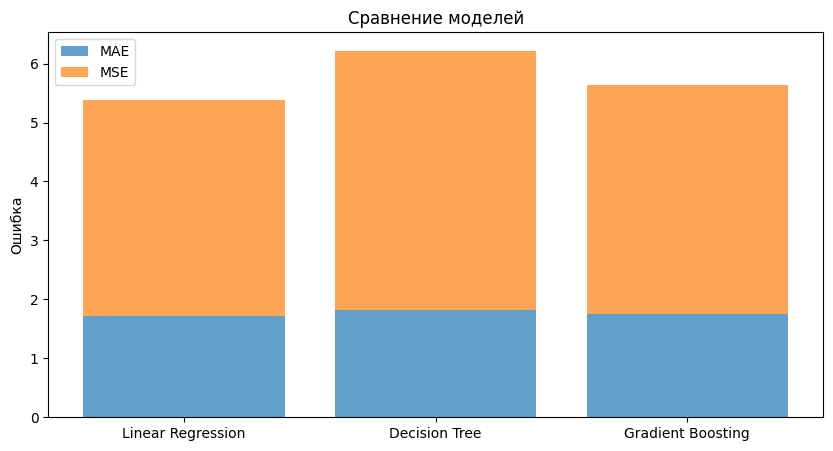

Лучшая модель: Linear Regression
Предсказания:
     Actual  Predicted
691    0.00   1.451043
458    0.00   1.298045
287    3.61   1.367268
469    0.00   1.095621
306    0.00   1.526276


In [1]:
# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Загрузка данных
item = 'Mroz'
package = 'Ecdat'
df = sm.datasets.get_rdataset(item, package, cache=True).data

# Очистка данных
df = df[['wagew', 'educw', 'agew', 'child6']].dropna()
df['child6'] = df['child6'].apply(lambda x: 1 if x == 'yes' else 0)

# Удаление выбросов (значения выше 95-го процентиля)
q_high = df['wagew'].quantile(0.95)
df = df[df['wagew'] <= q_high]

# Разделение данных на признаки и целевую переменную
X = df[['educw', 'agew', 'child6']]
y = df['wagew']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_predict, y_val, y_predict = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_predict_scaled = scaler.transform(X_predict)

# Полиномиальные признаки до 3-й степени
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_predict_poly = poly.transform(X_predict_scaled)

# Обучение моделей
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

# Гиперпараметры
param_grid_tree = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
param_grid_gb = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1]}

tree_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_tree, cv=3, scoring='neg_mean_squared_error')
gb_cv = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, scoring='neg_mean_squared_error')

results = {}
for name, model in models.items():
    if name == "Decision Tree":
        model = tree_cv.fit(X_train_poly, y_train)
    elif name == "Gradient Boosting":
        model = gb_cv.fit(X_train_poly, y_train)
    else:
        model.fit(X_train_poly, y_train)
    
    y_pred = model.predict(X_val_poly)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "Model": model}

# Вывод результатов
print("Результаты моделей:")
for name, metrics in results.items():
    print(f"{name}: MAE={metrics['MAE']:.2f}, MSE={metrics['MSE']:.2f}")

# Визуализация результатов
names = list(results.keys())
mae_values = [metrics['MAE'] for metrics in results.values()]
mse_values = [metrics['MSE'] for metrics in results.values()]

plt.figure(figsize=(10, 5))
plt.bar(names, mae_values, alpha=0.7, label='MAE')
plt.bar(names, mse_values, alpha=0.7, label='MSE', bottom=mae_values)
plt.title("Сравнение моделей")
plt.ylabel("Ошибка")
plt.legend()
plt.show()

# Лучшая модель
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = results[best_model_name]['Model']
print(f"Лучшая модель: {best_model_name}")

# Финальный прогноз
final_predictions = best_model.predict(X_predict_poly)
predictions_df = pd.DataFrame({"Actual": y_predict, "Predicted": final_predictions})
print("Предсказания:")
print(predictions_df.head())


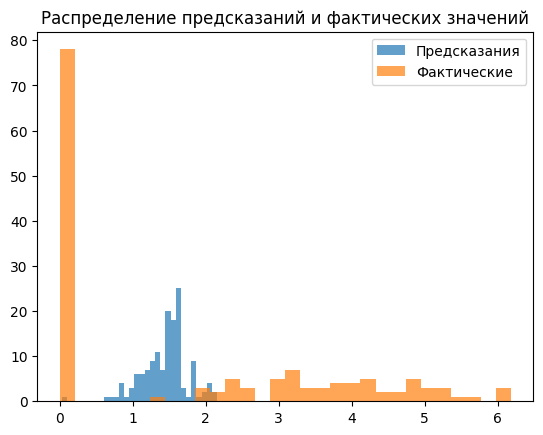

In [2]:
plt.hist(predictions_df['Predicted'], bins=30, alpha=0.7, label="Предсказания")
plt.hist(predictions_df['Actual'], bins=30, alpha=0.7, label="Фактические")
plt.legend()
plt.title("Распределение предсказаний и фактических значений")
plt.show()

XGBoost: MAE=1.68, MSE=4.28


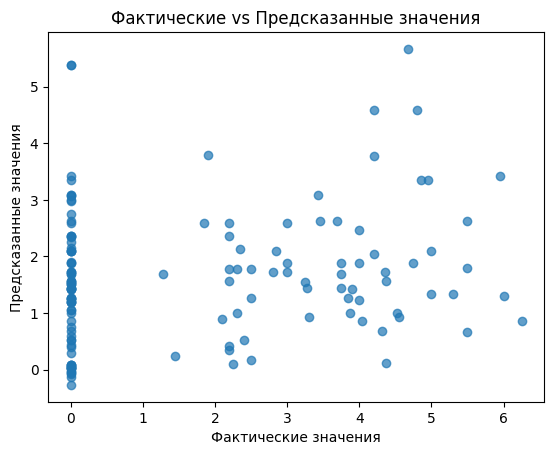

In [10]:
# Добавление стратифицированного разбиения для дисбаланса
from sklearn.model_selection import StratifiedKFold

# Убедимся, что границы уникальны, добавив небольшой запас к максимальному значению
# Исправление: Убедимся, что количество меток соответствует количеству интервалов
bins = [-1, 0.1, 5, 10, max(10, y.max()) + 0.1]  # Добавляем небольшой запас к максимальному значению
labels = [0, 1, 2, 3]  # Количество меток = len(bins) - 1
y_binned = pd.cut(y, bins=bins, labels=labels, include_lowest=True)  # Категоризация


# Преобразование целевой переменной для бинов
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y_binned, random_state=42)

# Использование более сложной модели
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, random_state=42)
xgb.fit(X_train_poly, y_train)

# Оценка модели
y_pred = xgb.predict(X_val_poly)
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
print(f"XGBoost: MAE={mae:.2f}, MSE={mse:.2f}")

# Визуализация и сравнение
predictions_df = pd.DataFrame({"Actual": y_val, "Predicted": y_pred})
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'], alpha=0.7)
plt.title("Фактические vs Предсказанные значения")
plt.xlabel("Фактические значения")
plt.ylabel("Предсказанные значения")
plt.show()
